# Grad Cam

The strategy is defined as follows:

-Load the VGG19 model

-Find its last convolutional layer

-Compute the most probable class

-Take the gradient of the class logit with respect to the activation maps we have just obtained

-Pool the gradients

-Weight the channels of the map by the corresponding pooled gradients

-Interpolate the heat-map

In [1]:
#!pip install grad-cam

In [32]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, EigenGradCAM, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from collections import OrderedDict
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from src.utils.gcs_utils import *
from src.models.model_factory import model_factory
from torchvision.models import resnet50
from torch import nn
import pickle
from PIL import Image
import timm
import pickle


In [3]:
def image_reader(bucket, image):
    image_read = cv2.cvtColor(cv2.imdecode(np.asarray(bytearray(bucket.blob(image).download_as_string()), dtype=np.uint8),cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB)
    return image_read


In [4]:
bucket = get_bucket_gcs('oro-ds-test-bucket')
# blob = bucket.blob('sdd_acne_files/Merged_for_ensemble/vit.pth')
# blob._chunk_size = 8388608  # 1024 * 1024 B * 16 = 8 MB
# blob.download_to_filename('vit.pth')

In [ ]:
images = ['sdd_acne_files/shanel_images/PXL_20211114_184920576.jpg','sdd_acne_files/shanel_images/PXL_20220419_203530160.jpg',
         'sdd_acne_files/shanel_images/PXL_20220506_215317846.jpg','sdd_acne_files/shanel_images/PXL_20220509_191251054.MP.jpg',
         'sdd_acne_files/shanel_images/PXL_20210312_145539241.jpg']
diseases = [14, 9, 13, 24, 0, 24]

In [16]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
resizing =  transforms.Resize((224,224))
normalize = transforms.Normalize(mean=mean, std=std)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

In [17]:
blob = bucket.blob('sdd_acne_files/Merged_for_ensemble/vit_class_indices.pkl')
pickle_in = blob.download_as_string()
my_dictionary = pickle.loads(pickle_in)
CLS2IDX = my_dictionary


In [18]:
CLS2IDX

{0: 'acne_mixed',
 1: 'acne_scars',
 2: 'atopic_dermatitis',
 3: 'acne_cystic',
 4: 'acne_excoriated',
 5: 'rosacea_inflammatory',
 6: 'rosacea_erythemato_telangiectasique',
 7: 'acne_comedos',
 8: 'peri_oral_dermatitis',
 9: 'seborrheic_keratosis',
 10: 'psoriasis_vulgar',
 11: 'seborrheic_dermatitis',
 12: 'nummular_eczema',
 13: 'tinea_versicolor',
 14: 'chronic_hand_eczema',
 15: 'vulgar_warts',
 16: 'folliculitis',
 17: 'alopecia_androgenic',
 18: 'dyshidrosis',
 19: 'nevus',
 20: 'melasma',
 21: 'alopecia_areata',
 22: 'intertrigo',
 23: 'urticaria',
 24: 'vitiligo',
 25: 'keratosis_pilaris',
 26: 'molluscum',
 27: 'cheilitis_eczematous',
 28: 'tinea_corporis',
 29: 'prurigo_nodularis',
 30: 'actinic_keratosis',
 31: 'genital_warts',
 32: 'plane_warts',
 33: 'pityriasis_rosae',
 34: 'melanonychia',
 35: 'psoriasis_pustular_palmoplantar',
 36: 'granuloma_annulare',
 37: 'psoriasis_guttate',
 38: 'lichen_simplex_chronicus',
 39: 'shingles',
 40: 'herpes_simplex'}

In [19]:
images = ['sdd_acne_files/shanel_images/PXL_20211114_184920576.jpg','sdd_acne_files/shanel_images/PXL_20220419_203530160.jpg',
         'sdd_acne_files/shanel_images/PXL_20220506_215317846.jpg','sdd_acne_files/shanel_images/PXL_20220509_191251054.MP.jpg',
         'sdd_acne_files/shanel_images/PXL_20210312_145539241.jpg']
diseases = [14, 9, 13, 24, 0, 24]

In [20]:
def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

# BIT Model

In [21]:
# initialize ViT pretrained
model = model = timm.create_model('resnetv2_101x1_bitm', pretrained=True, num_classes=41)
state_dict = torch.load('bit.pth')
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]  # remove `module.`
    new_state_dict[name] = v
print("[Loading Weights to the Model]")
model.load_state_dict(new_state_dict)
model.cuda()
model.eval()
print('model loaded')

[Loading Weights to the Model]
model loaded


/home/18193/sdd-env/env_acne/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Top 5 classes:
	14 : chronic_hand_eczema            		value = 15.318	 prob = 56.7%
	18 : dyshidrosis                    		value = 15.047	 prob = 43.2%
	35 : psoriasis_pustular_palmoplantar		value = 8.736	 prob = 0.1%
	10 : psoriasis_vulgar               		value = 5.931	 prob = 0.0%
	2 : atopic_dermatitis              		value = 5.598	 prob = 0.0%
Top 5 classes:
	9 : seborrheic_keratosis		value = 16.508	 prob = 68.2%
	19 : nevus               		value = 15.726	 prob = 31.2%
	15 : vulgar_warts        		value = 11.716	 prob = 0.6%
	7 : acne_comedos        		value = 5.579	 prob = 0.0%
	30 : actinic_keratosis   		value = 4.862	 prob = 0.0%
Top 5 classes:
	13 : tinea_versicolor		value = 14.351	 prob = 99.9%
	16 : folliculitis    		value = 5.997	 prob = 0.0%
	19 : nevus           		value = 5.037	 prob = 0.0%
	23 : urticaria       		value = 4.294	 prob = 0.0%
	10 : psoriasis_vulgar		value = 4.021	 prob = 0.0%
Top 5 classes:
	30 : actinic_keratosis                  		value = 11.836	 prob = 71.3%


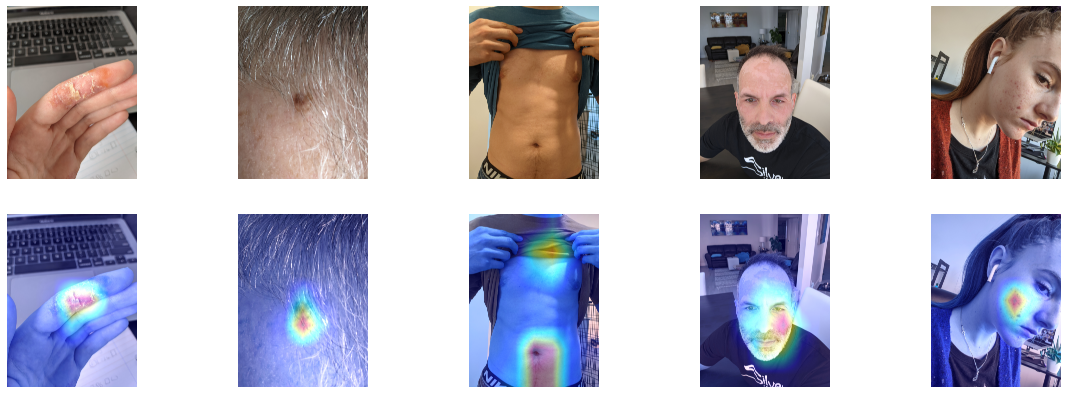

In [28]:
fig, axs = plt.subplots(2, len(images), figsize=(20,7))
for i, image in enumerate(images): 
    img = image_reader(bucket, image)
    img = Image.fromarray(img)
    dog_cat_image = transform(img)
    axs[0, i].imshow(img);
    axs[0, i].axis('off');

    target_layers = model.stages[-1].blocks #  [model.layer4[-1]]

    img = image_reader(bucket, image)
   # img = Image.fromarray(img)
    resizing =  transforms.Resize((224,224))
    
    input_tensor = transform(Image.fromarray(img)).unsqueeze(0).cuda() # Create an input tensor image for your model..
    cam = EigenGradCAM(model=model, target_layers=target_layers, use_cuda=True)
    targets =[ClassifierOutputTarget(diseases[i])]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    heatmap = grayscale_cam[0, :]
    #heatmap = show_cam_on_image(resizing(input_tensor).squeeze(0).view(224,224,3).cpu().numpy(), grayscale_cam)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite('./map.jpg', superimposed_img)
    img = np.array(Image.open('./map.jpg'))
    #axs[1].imshow(cat);
    #axs[1].axis('off');
    axs[1, i].imshow(img);
    axs[1, i].axis('off');
    output = model(dog_cat_image.unsqueeze(0).cuda())
    print_top_classes(output)
#plt.savefig('maps.pdf')

# ResNext model

In [70]:
model = model_factory('resnext101_32x4d', 41, freeze_layers=False, percentage_freeze= 0, pretrained=True, ml_decoder=False)
state_dict = torch.load('resnext101_32x4d.pth')
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]  # remove `module.`
    new_state_dict[name] = v
print("[Loading Weights to the Model]")
model.load_state_dict(new_state_dict)
model.cuda()
model.eval()
print('model loaded')

[Loading Weights to the Model]
model loaded


Top 5 classes:
	14 : chronic_hand_eczema            		value = 11.689	 prob = 49.9%
	18 : dyshidrosis                    		value = 11.684	 prob = 49.6%
	35 : psoriasis_pustular_palmoplantar		value = 6.778	 prob = 0.4%
	2 : atopic_dermatitis              		value = 5.245	 prob = 0.1%
	28 : tinea_corporis                 		value = 3.605	 prob = 0.0%
Top 5 classes:
	19 : nevus               		value = 8.537	 prob = 54.3%
	15 : vulgar_warts        		value = 7.836	 prob = 27.0%
	9 : seborrheic_keratosis		value = 7.406	 prob = 17.5%
	31 : genital_warts       		value = 3.801	 prob = 0.5%
	16 : folliculitis        		value = 3.052	 prob = 0.2%
Top 5 classes:
	1 : acne_scars      		value = 7.684	 prob = 50.8%
	13 : tinea_versicolor		value = 7.406	 prob = 38.4%
	16 : folliculitis    		value = 4.837	 prob = 2.9%
	7 : acne_comedos    		value = 4.646	 prob = 2.4%
	10 : psoriasis_vulgar		value = 4.124	 prob = 1.4%
Top 5 classes:
	11 : seborrheic_dermatitis              		value = 9.647	 prob = 86.8%
	5 :

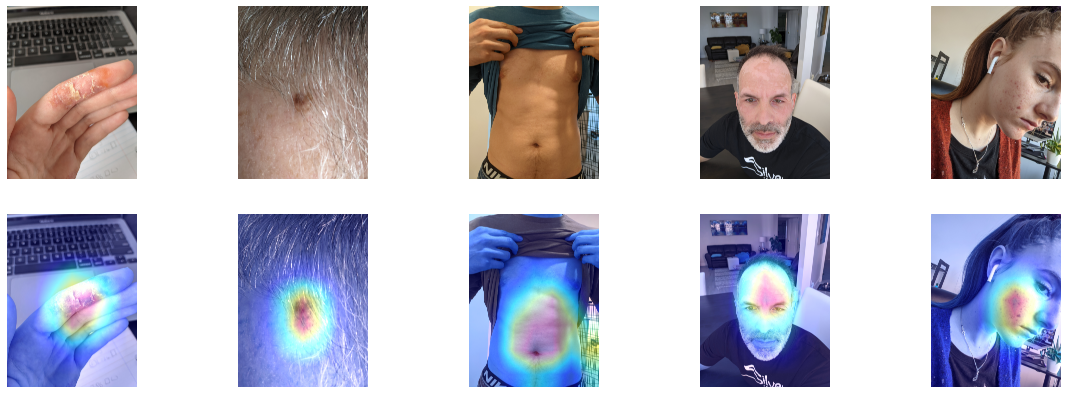

In [17]:
fig, axs = plt.subplots(2, len(images), figsize=(20,7))
for i, image in enumerate(images): 
    img = image_reader(bucket, image)
    img = Image.fromarray(img)
    dog_cat_image = transform(img)
    output = model(dog_cat_image.unsqueeze(0).cuda())
    print_top_classes(output)
    axs[0, i].imshow(img);
    axs[0, i].axis('off');

    target_layers =model.features[-1]

    img = image_reader(bucket, image)
   # img = Image.fromarray(img)
    resizing =  transforms.Resize((224,224))
    
    input_tensor = dog_cat_image.unsqueeze(0).cuda() # Create an input tensor image for your model..
    cam = EigenGradCAM(model=model, target_layers=target_layers, use_cuda=True)
    targets =[ClassifierOutputTarget(diseases[i])]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    heatmap = grayscale_cam[0, :]
    #heatmap = show_cam_on_image(resizing(input_tensor).squeeze(0).view(224,224,3).cpu().numpy(), grayscale_cam)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite('./map.jpg', superimposed_img)
    img = np.array(Image.open('./map.jpg'))
    #axs[1].imshow(cat);
    #axs[1].axis('off');
    axs[1, i].imshow(img);
    axs[1, i].axis('off');
plt.savefig('maps.pdf')
